Remaining to-dos:

- Update dataset representations
    - Word onset/offset sample
    - Word-level
        - phonetic representation
        - semantic ID (I guess just a word string)
- Define basic bag-of-diphone prediction task
- Support chopping off last N layers and adding more structure

In [1]:
import numpy as np
import pandas as pd
import torch
import transformers
from transformers import AutoConfig

In [2]:
%load_ext autoreload
%autoreload 2

In [14]:
from transformers import Wav2Vec2Model
from models.transformer import Wav2Vec2ForSpeechClassification, DataCollator, \
    drop_wav2vec_layers
from utils.timit import TimitCorpus

In [4]:
corpus = TimitCorpus()

In [5]:
# Load wav2vec2
model_name_or_path = "facebook/wav2vec2-base-960h"

processor = transformers.Wav2Vec2Processor.from_pretrained(model_name_or_path)

config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=corpus.num_speakers)
setattr(config, "pooling_mode", "mean")

In [17]:
model = Wav2Vec2ForSpeechClassification.from_pretrained(
    model_name_or_path, config=config)

model.freeze_feature_extractor()
model.wav2vec2 = drop_wav2vec_layers(model.wav2vec2, 10)

Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'wav2vec2.masked_spec_embed', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Prepare huggingface-friendly dataset

In [19]:
from datasets import Dataset

all_speakers = sorted(corpus._df.groupby("speaker").groups.keys())
all_dialects = sorted(corpus._df.groupby("dialect").groups.keys())

def gen():
    for (dialect, speaker, sentence_idx), audio in corpus.sounds.items():
        yield {
            "input_values": audio,
            "labels": all_dialects.index(dialect),

            "speaker": speaker,
            "speaker_idx": all_speakers.index(speaker),
            "dialect": dialect,
            "sentence_idx": sentence_idx
        }

dataset = Dataset.from_generator(gen)
dataset = dataset.train_test_split(test_size=0.2)


## Train

In [20]:
def compute_metrics(p: transformers.EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)

    return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

In [21]:
coll = DataCollator(processor=processor, padding=True)

In [22]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="testrun",
    group_by_length=True,
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=30,
    gradient_accumulation_steps=2,
    save_steps=3,
    eval_steps=10,
    logging_steps=2,
    learning_rate=1e-4,
    save_total_limit=2,
    use_cpu=True,
)

trainer = Trainer(
    model=model,
    data_collator=coll,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=processor.feature_extractor,
)

In [23]:
trainer.train()

  0%|          | 0/3450 [00:00<?, ?it/s]

{'loss': 6.1151, 'learning_rate': 9.994202898550726e-05, 'epoch': 0.02}
{'loss': 6.0484, 'learning_rate': 9.98840579710145e-05, 'epoch': 0.03}
{'loss': 5.962, 'learning_rate': 9.982608695652175e-05, 'epoch': 0.05}
{'loss': 5.8331, 'learning_rate': 9.976811594202899e-05, 'epoch': 0.07}
{'loss': 5.6863, 'learning_rate': 9.971014492753625e-05, 'epoch': 0.09}


  0%|          | 0/116 [00:00<?, ?it/s]

[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [66]:
def predict(batch):
    features = processor(batch["input_values"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values

    with torch.no_grad():
        logits = model(input_values).logits 

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

eval_result = dataset["test"].map(predict, batched=True, batch_size=8)

Map:   0%|          | 0/924 [00:00<?, ? examples/s]

/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [74]:
# y_true = [all_dialects[i] for i in eval_result["labels"]]
# y_pred = [all_dialects[i] for i in eval_result["predicted"]]
y_true = eval_result["labels"]
y_pred = eval_result["predicted"]

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_true, y_pred, target_names=all_dialects))

              precision    recall  f1-score   support

         DR1       0.00      0.00      0.00        82
         DR2       0.00      0.00      0.00       160
         DR3       0.18      0.06      0.09       165
         DR4       0.00      0.00      0.00       145
         DR5       0.13      0.46      0.20       126
         DR6       0.00      0.00      0.00        62
         DR7       0.14      0.38      0.20       149
         DR8       0.00      0.00      0.00        35

    accuracy                           0.13       924
   macro avg       0.06      0.11      0.06       924
weighted avg       0.07      0.13      0.08       924



/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

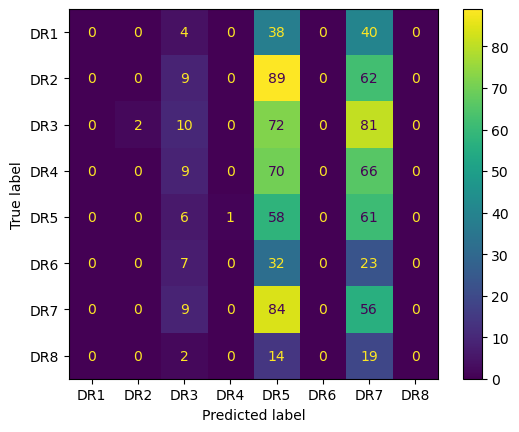

In [75]:
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=all_dialects).plot()

In [38]:
# Generate input/output samples

# Maximum length of a word, in phones
max_word_length = 10

# Include this many phones to the left and right of a target word token
width_lookback, width_lookforward = 5, 5

samples = torch.zeros((corpus.num_word_instances,
                       max_word_length + width_lookback + width_lookforward,
                       corpus.num_phone_types))

i = 0
# TODO assumes contiguous phone_idx. is this right?
for sentence_key, sentence_row in corpus._df.groupby(["dialect", "speaker", "sentence_idx"]):
    phone_idxs = sentence_row.index.get_level_values("phone_idx")
    for word_idx, phones in sentence_row.groupby("word_idx"):
        word_phone_idxs = phones.index.get_level_values("phone_idx")
        phone_onset, phone_offset = word_phone_idxs[0], word_phone_idxs[-1]

        window_left = max(0, phone_onset - width_lookback)
        window_right = min(phone_offset + width_lookforward, len(phones))

        input_span = sentence_row.loc[(phone_idxs >= window_left) & (phone_idxs < window_right - 1)]

        # TODO convert this into actual sample in torch tensor

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]
[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]
[False False False False False False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  Tr